<a href="https://colab.research.google.com/github/mycelialmeese/Deep-Learning-Classwork-Week-4/blob/main/week_4_kaggle_nlp_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Week 4 Kaggle Mini Project: NLP Processing with Disaster Tweets**

## **Background**
The goal of this project is to make a binary classifier using a recursive neural network for tweets to determining whether or not they are about a real disaster. The dataset comes from the Kaggle competition: [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview). Developing a vectorization process for words is outside of the scope of this project so we will pull word embeddings are from the [GloVe](https://nlp.stanford.edu/projects/glove/) from Stanford using the glove.6B.300d.txt file.

In [1]:
# Loading dependencies
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from PIL import Image
import os

from keras.models import Sequential
from keras.layers import  Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GRU
from keras.models import Sequential

In [2]:
# In order to run this please place your the associated files in the corresponding variable names

wiki_GloVe_location = "/content/drive/MyDrive/Colab Notebooks/GloVe/glove.6B.300d.txt"
train_path = "/content/drive/MyDrive/Colab Notebooks/GloVe/train.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/GloVe/test.csv"

In [3]:
#Opening the GloVe file and putting it into a dictionary for later use
GloVe = open(wiki_GloVe_location, encoding='utf-8')

embeddings_dic = {}
for line in GloVe:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_dic[word] = coefs
GloVe.close()

In [4]:
# Reading in the Training CSV, tokenizing the words, and looking at tweet length

train_csv = pd.read_csv(train_path)
train_csv
train_csv['tweet_length'] = train_csv['text'].apply(lambda x : len(x.split()))
longest_tweet = train_csv['tweet_length'].max()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_csv['text'])
word_index = tokenizer.word_index

#Embedding the tokenized words
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_dic.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.21004   , -0.39556   , -0.46031001, ..., -0.44566   ,
         0.69391   ,  0.17159   ],
       [-0.13122   ,  0.12142   ,  0.060673  , ..., -0.2676    ,
        -0.25742   ,  0.44606999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## **EDA**
We will take a brief look at the training data. First, let's plot a histogram of the length of the tweets.

Text(0.5, 1.0, 'Training Data Tweet Length Histogram')

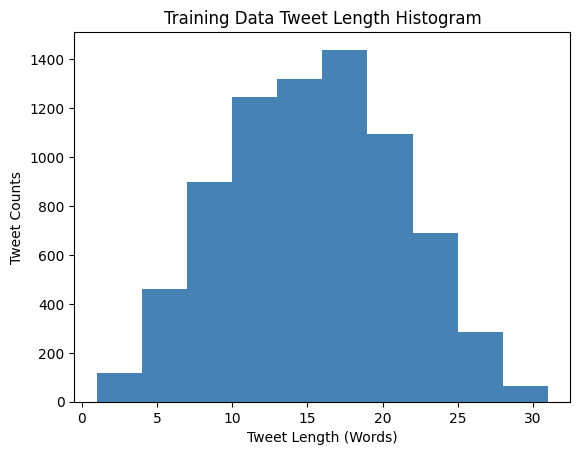

In [40]:
# Plotting Data Attributes

plt.hist(train_csv['tweet_length'], color='steelblue')
plt.ylabel('Tweet Counts')
plt.xlabel('Tweet Length (Words)')
plt.title('Training Data Tweet Length Histogram')

So the tweets are centered around 15 words without any craxy outlier suggesting we have good data and don't need to do much cleaning. Next let's plot the distribution of positive vs negative cases.

Text(0.5, 1.0, 'Training Data: Actual Disaster Cases')

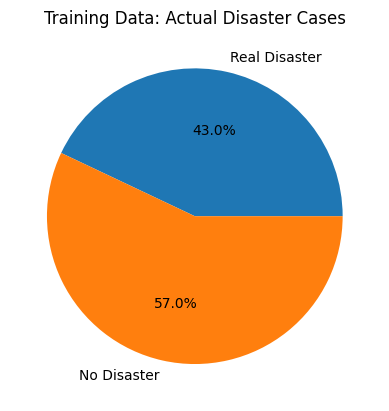

In [43]:
pos_cases = train_csv.loc[train_csv['target'] == 1]
neg_cases = train_csv.loc[train_csv['target'] == 0]

case_labels = 'Real Disaster', 'No Disaster'
sizes = [len(pos_cases), len(neg_cases)]
plt.pie(sizes, labels = case_labels,  autopct='%1.1f%%')
plt.title('Training Data: Actual Disaster Cases')

## **Model Architecture & Results / Analysis**

As stated earlier we will be using the GloVe model for word embedding. The first thing we will look at is whether or not to use an LTSM or GRU layer in our model. We will keep the other components of the NN the same and monitor accuracy.

From there we will choose a model to move forward with and look at things like dropout/regularization and model complexity (depth and # of neurons).

In [5]:
GRU_model = Sequential()
GRU_model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=longest_tweet,
                    trainable=False))

GRU_model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
GRU_model.add(Dense(128, activation="relu"))
GRU_model.add(Dropout(0.5))
GRU_model.add(BatchNormalization())
GRU_model.add(Dense(64, activation="relu"))
GRU_model.add(Dropout(0.5))
GRU_model.add(Dense(1, activation="sigmoid"))

GRU_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
GRU_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,810,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,810,300 (25.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,810,300 (25.98 MB)

In [6]:
seqs = tokenizer.texts_to_sequences(train_csv["text"])
X_train = pad_sequences(seqs, maxlen = longest_tweet)
X_train_div = X_train[:int(.2*len(X_train))]
y_train = train_csv['target'][:int(.2*len(X_train))]
X_val = X_train[int(.2*len(X_train)):]
y_val = train_csv['target'][int(.2*len(X_train)):]

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
lr_schedule = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss",patience=4, restore_best_weights=True)

GRU_hist = GRU_model.fit(X_train_div, y_train,
            epochs=10,
            validation_data= [X_val, y_val],
            callbacks=[lr_schedule, early_stop])

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 454ms/step - accuracy: 0.5515 - loss: 0.7583 - val_accuracy: 0.6281 - val_loss: 0.6532 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 353ms/step - accuracy: 0.7408 - loss: 0.5665 - val_accuracy: 0.7485 - val_loss: 0.5509 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 327ms/step - accuracy: 0.8142 - loss: 0.4784 - val_accuracy: 0.7664 - val_loss: 0.5339 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 343ms/step - accuracy: 0.7997 - loss: 0.4728 - val_accuracy: 0.7629 - val_loss: 0.5145 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 340ms/step - accuracy: 0.8265 - loss: 0.4142 - val_accuracy: 0.7393 - val_loss: 0.5220 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 314ms/step - accuracy: 0.8426 - loss: 0.3761 - val_accuracy: 0.7637 - val_loss: 0.5035 - learning_rate: 0.0010
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 315ms/step - accuracy: 0.8556 - loss: 0.

In [7]:
LTSM_model = Sequential()
LTSM_model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=longest_tweet,
                    trainable=False))

LTSM_model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
LTSM_model.add(Dense(128, activation="relu"))
LTSM_model.add(Dropout(0.5))
LTSM_model.add(BatchNormalization())
LTSM_model.add(Dense(64, activation="relu"))
LTSM_model.add(Dropout(0.5))
LTSM_model.add(Dense(1, activation="sigmoid"))

LTSM_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

LTSM_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     6,810,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,810,300 (25.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,810,300 (25.98 MB)

In [8]:
seqs = tokenizer.texts_to_sequences(train_csv["text"])
X_train = pad_sequences(seqs, maxlen = longest_tweet)
X_train_div = X_train[:int(.2*len(X_train))]
y_train = train_csv['target'][:int(.2*len(X_train))]
X_val = X_train[int(.2*len(X_train)):]
y_val = train_csv['target'][int(.2*len(X_train)):]

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
lr_schedule = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss",patience=4, restore_best_weights=True)

LTSM_hist = LTSM_model.fit(X_train_div, y_train,
            epochs=10,
            validation_data= [X_val, y_val],
            callbacks=[lr_schedule, early_stop])

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 340ms/step - accuracy: 0.4713 - loss: 0.9910 - val_accuracy: 0.6465 - val_loss: 0.6491 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 333ms/step - accuracy: 0.7234 - loss: 0.5768 - val_accuracy: 0.6388 - val_loss: 0.6212 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 366ms/step - accuracy: 0.7421 - loss: 0.5185 - val_accuracy: 0.7582 - val_loss: 0.5232 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 542ms/step - accuracy: 0.8061 - loss: 0.4475 - val_accuracy: 0.7418 - val_loss: 0.5317 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 496ms/step - accuracy: 0.8474 - loss: 0.4034 - val_accuracy: 0.7679 - val_loss: 0.4935 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 316ms/step - accuracy: 0.8205 - loss: 0.4518 - val_accuracy: 0.7600 - val_loss: 0.5158 - learning_rate: 0.0010
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step - accuracy: 0.8660 - loss: 0.

Text(0.5, 0.98, 'Training Performance Metrics: LSTM vs GRU')

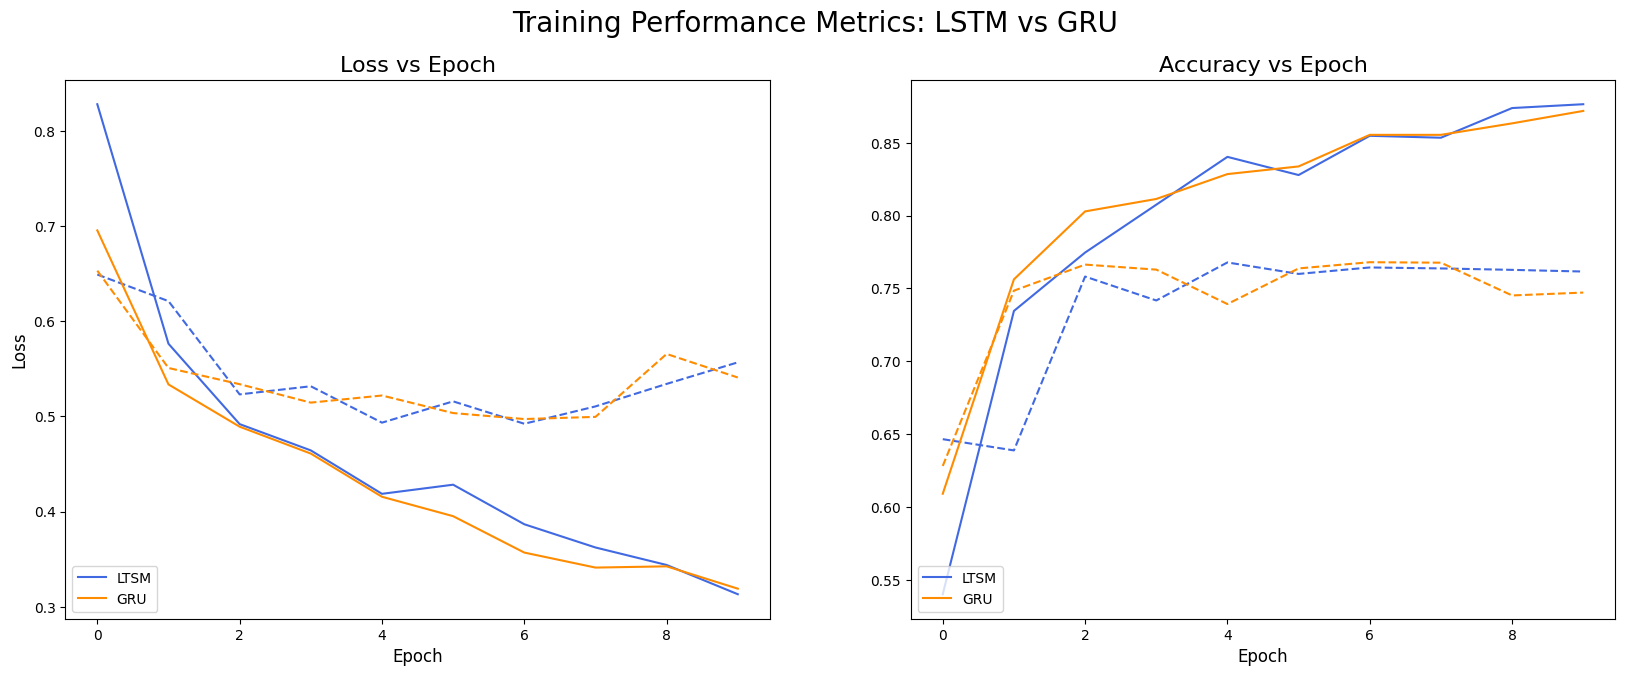

In [10]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

ax[0].plot(LTSM_hist.history['val_loss'], color='royalblue', linestyle='--')
ax[0].plot(LTSM_hist.history['loss'], color='royalblue', label='LTSM')
ax[0].plot(GRU_hist.history['val_loss'], color='darkorange', linestyle='--')
ax[0].plot(GRU_hist.history['loss'], color='darkorange', label='GRU')
ax[0].set_title('Loss vs Epoch', fontsize=16)
ax[0].legend(loc='lower left')
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].set_xlabel('Epoch', fontsize=12)

ax[1].plot(LTSM_hist.history['val_accuracy'], color='royalblue', linestyle='--')
ax[1].plot(LTSM_hist.history['accuracy'], color='royalblue', label='LTSM')
ax[1].plot(GRU_hist.history['val_accuracy'], color='darkorange', linestyle='--')
ax[1].plot(GRU_hist.history['accuracy'], color='darkorange', label='GRU')
ax[1].set_title('Accuracy vs Epoch', fontsize=16)
ax[1].legend(loc='lower left')
ax[1].set_xlabel('Epoch', fontsize=12)

fig.suptitle('Training Performance Metrics: LSTM vs GRU', fontsize=20)

The LTSM and GRU models have very similar behaviors: both are quick to plateau at validaiton accuracy and loss with signs of overfitting at loss (slight increase towards last 2 epochs). Meanwhile the training loss continues to decrease - this implies some overfitting likely due to a combination of too small a data set and not enough regularization in the model.

To iterate we will move forward with the GRU model, increase the bidirectional layer dropout from 0.2 to 0.5, and bump up the training data from 20% to 80% of all available data.

In [11]:
GRU_2_model = Sequential()
GRU_2_model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=longest_tweet,
                    trainable=False))

GRU_2_model.add(Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.2)))
GRU_2_model.add(Dense(128, activation="relu"))
GRU_2_model.add(Dropout(0.5))
GRU_2_model.add(BatchNormalization())
GRU_2_model.add(Dense(64, activation="relu"))
GRU_2_model.add(Dropout(0.5))
GRU_2_model.add(Dense(1, activation="sigmoid"))

GRU_2_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
GRU_2_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     6,810,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,810,300 (25.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,810,300 (25.98 MB)

In [12]:
seqs = tokenizer.texts_to_sequences(train_csv["text"])
X_train = pad_sequences(seqs, maxlen = longest_tweet)
X_train_div = X_train[:int(.8*len(X_train))]
y_train = train_csv['target'][:int(.8*len(X_train))]
X_val = X_train[int(.8*len(X_train)):]
y_val = train_csv['target'][int(.8*len(X_train)):]

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
lr_schedule = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss",patience=4, restore_best_weights=True)

GRU_2_hist = GRU_2_model.fit(X_train_div, y_train,
            epochs=10,
            validation_data= [X_val, y_val],
            callbacks=[lr_schedule, early_stop])

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.5964 - loss: 0.7423 - val_accuracy: 0.7859 - val_loss: 0.5143 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 44s 186ms/step - accuracy: 0.7298 - loss: 0.5611 - val_accuracy: 0.7978 - val_loss: 0.4761 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 169ms/step - accuracy: 0.7704 - loss: 0.5170 - val_accuracy: 0.8083 - val_loss: 0.4324 - learning_rate: 0.0010
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/step - accuracy: 0.7936 - loss: 0.4874 - val_accuracy: 0.8096 - val_loss: 0.4270 - learning_rate: 0.0010
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.7998 - loss: 0.4577 - val_accuracy: 0.8043 - val_loss: 0.4228 - learning_rate: 0.0010
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - accuracy: 0.8031 - loss: 0.4589 - val_accuracy: 0.8135 - val_loss: 0.4054 - learning_rate: 0.0010
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 167ms/step - accuracy: 0.8

Text(0.5, 0.98, 'Training Performance Metrics: LSTM vs GRU')

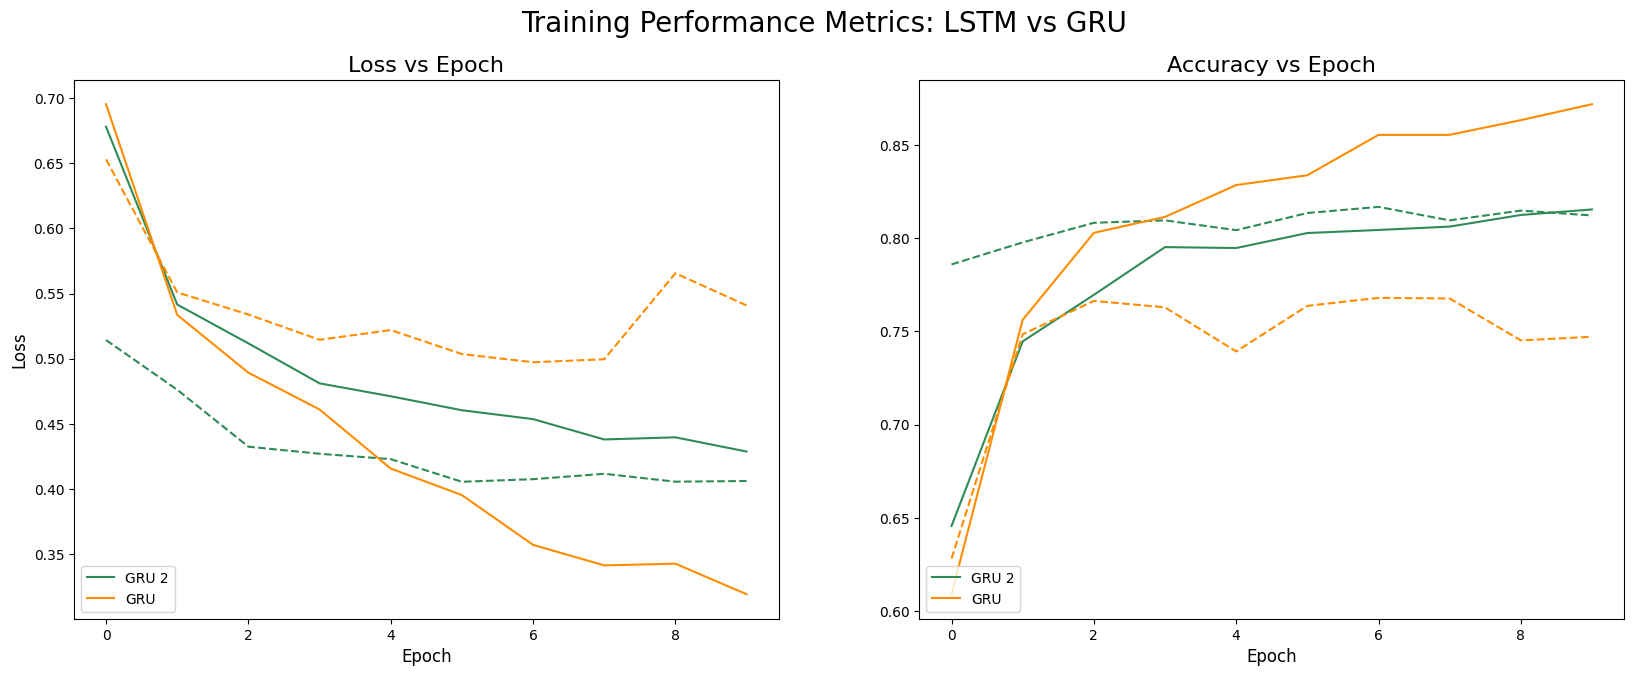

In [13]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

ax[0].plot(GRU_2_hist.history['val_loss'], color='seagreen', linestyle='--')
ax[0].plot(GRU_2_hist.history['loss'], color='seagreen', label='GRU 2')
ax[0].plot(GRU_hist.history['val_loss'], color='darkorange', linestyle='--')
ax[0].plot(GRU_hist.history['loss'], color='darkorange', label='GRU')
ax[0].set_title('Loss vs Epoch', fontsize=16)
ax[0].legend(loc='lower left')
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].set_xlabel('Epoch', fontsize=12)

ax[1].plot(GRU_2_hist.history['val_accuracy'], color='seagreen', linestyle='--')
ax[1].plot(GRU_2_hist.history['accuracy'], color='seagreen', label='GRU 2')
ax[1].plot(GRU_hist.history['val_accuracy'], color='darkorange', linestyle='--')
ax[1].plot(GRU_hist.history['accuracy'], color='darkorange', label='GRU')
ax[1].set_title('Accuracy vs Epoch', fontsize=16)
ax[1].legend(loc='lower left')
ax[1].set_xlabel('Epoch', fontsize=12)

fig.suptitle('Training Performance Metrics: LSTM vs GRU', fontsize=20)

The increased dropout and larger dataset helped improve on the GRU model by preventing overfitting. However, we still see a plateau in the validation acuraccy at ~80%. We achieve this rate rather quiclkly and its unclear whether increasing the epochs would improve this as validaiton loss is also plateauing. Next we should try increasing the model complexity by increasing the neurons in the bidirectional model and compare that to adding another bidirectional layer. We will do this by adding another layer to the GRU 2 and call this GRU_2_layer and for the increased neuron layer we will call that GRU_128. These should still have equivalent numbers of neurons.

In [14]:
GRU_128_model = Sequential()
GRU_128_model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=longest_tweet,
                    trainable=False))

GRU_128_model.add(Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2)))
GRU_128_model.add(Dense(128, activation="relu"))
GRU_128_model.add(Dropout(0.5))
GRU_128_model.add(BatchNormalization())
GRU_128_model.add(Dense(64, activation="relu"))
GRU_128_model.add(Dropout(0.5))
GRU_128_model.add(Dense(1, activation="sigmoid"))

GRU_128_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
GRU_128_model.summary()



GRU_2_layer_model = Sequential()
GRU_2_layer_model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=longest_tweet,
                    trainable=False))

GRU_2_layer_model.add(Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.2, return_sequences=True)))
GRU_2_layer_model.add(Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.2)))
GRU_2_layer_model.add(Dense(128, activation="relu"))
GRU_2_layer_model.add(Dropout(0.5))
GRU_2_layer_model.add(BatchNormalization())
GRU_2_layer_model.add(Dense(64, activation="relu"))
GRU_2_layer_model.add(Dropout(0.5))
GRU_2_layer_model.add(Dense(1, activation="sigmoid"))

GRU_2_layer_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
GRU_2_layer_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     6,810,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,810,300 (25.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,810,300 (25.98 MB)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     6,810,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,810,300 (25.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,810,300 (25.98 MB)

In [15]:
seqs = tokenizer.texts_to_sequences(train_csv["text"])
X_train = pad_sequences(seqs, maxlen = longest_tweet)
X_train_div = X_train[:int(.8*len(X_train))]
y_train = train_csv['target'][:int(.8*len(X_train))]
X_val = X_train[int(.8*len(X_train)):]
y_val = train_csv['target'][int(.8*len(X_train)):]

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
lr_schedule = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss",patience=4, restore_best_weights=True)

GRU_2_layer_hist = GRU_2_layer_model.fit(X_train_div, y_train,
            epochs=10,
            validation_data= [X_val, y_val],
            callbacks=[lr_schedule, early_stop])


seqs = tokenizer.texts_to_sequences(train_csv["text"])
X_train = pad_sequences(seqs, maxlen = longest_tweet)
X_train_div = X_train[:int(.8*len(X_train))]
y_train = train_csv['target'][:int(.8*len(X_train))]
X_val = X_train[int(.8*len(X_train)):]
y_val = train_csv['target'][int(.8*len(X_train)):]

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
lr_schedule = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss",patience=4, restore_best_weights=True)

GRU_128_hist = GRU_128_model.fit(X_train_div, y_train,
            epochs=10,
            validation_data= [X_val, y_val],
            callbacks=[lr_schedule, early_stop])

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 92s 402ms/step - accuracy: 0.5931 - loss: 0.7425 - val_accuracy: 0.7833 - val_loss: 0.5386 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 74s 388ms/step - accuracy: 0.7409 - loss: 0.5499 - val_accuracy: 0.8011 - val_loss: 0.4368 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 73s 385ms/step - accuracy: 0.7801 - loss: 0.4888 - val_accuracy: 0.7971 - val_loss: 0.4269 - learning_rate: 0.0010
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 71s 372ms/step - accuracy: 0.7835 - loss: 0.5024 - val_accuracy: 0.7991 - val_loss: 0.4312 - learning_rate: 0.0010
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 69s 363ms/step - accuracy: 0.7956 - loss: 0.4646 - val_accuracy: 0.8089 - val_loss: 0.4340 - learning_rate: 0.0010
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 69s 359ms/step - accuracy: 0.8026 - loss: 0.4585 - val_accuracy: 0.8129 - val_loss: 0.4187 - learning_rate: 0.0010
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 87s 453ms/step - accuracy: 0.8

Text(0.5, 0.98, 'Training Performance Metrics: LSTM vs GRU')

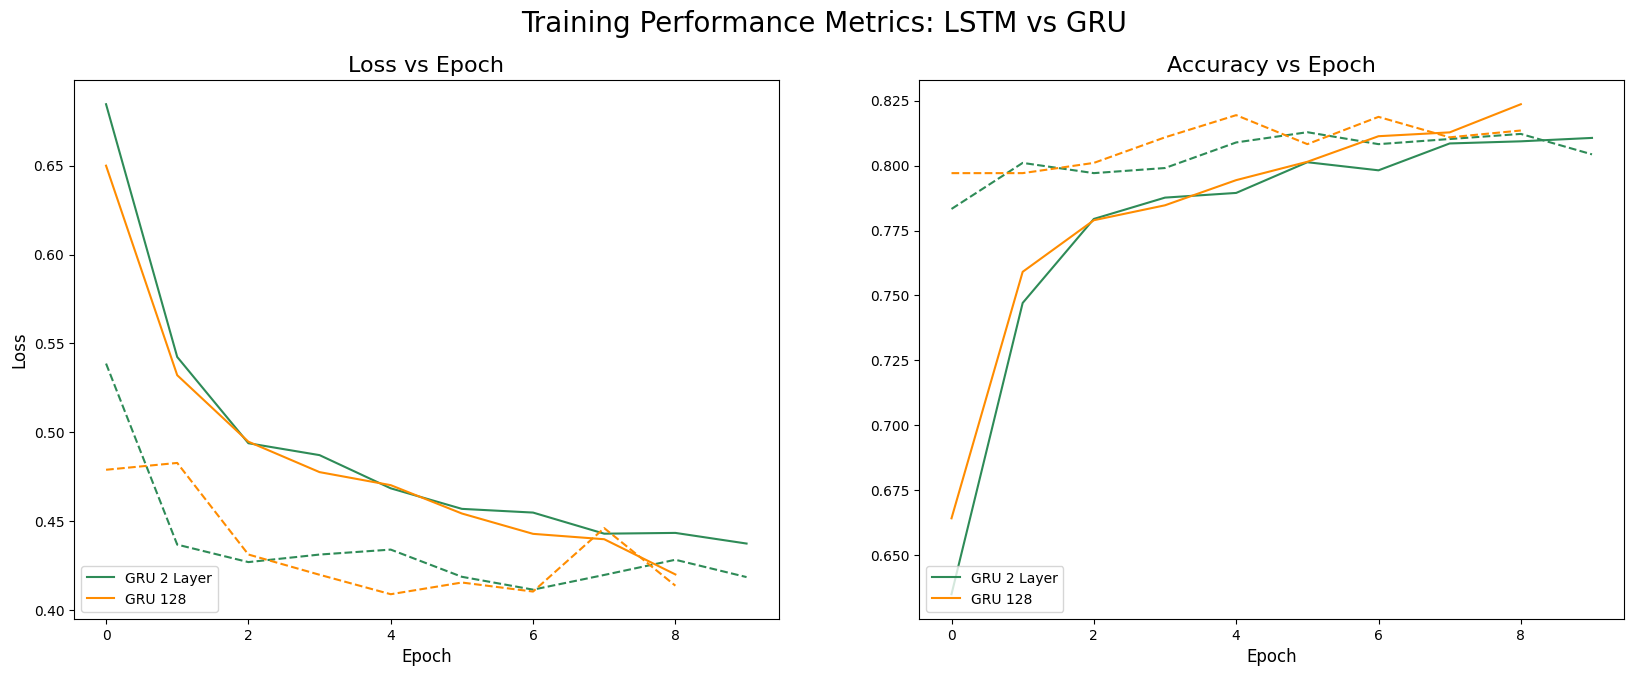

In [16]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

ax[0].plot(GRU_2_layer_hist.history['val_loss'], color='seagreen', linestyle='--')
ax[0].plot(GRU_2_layer_hist.history['loss'], color='seagreen', label='GRU 2 Layer')
ax[0].plot(GRU_128_hist.history['val_loss'], color='darkorange', linestyle='--')
ax[0].plot(GRU_128_hist.history['loss'], color='darkorange', label='GRU 128')
ax[0].set_title('Loss vs Epoch', fontsize=16)
ax[0].legend(loc='lower left')
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].set_xlabel('Epoch', fontsize=12)

ax[1].plot(GRU_2_layer_hist.history['val_accuracy'], color='seagreen', linestyle='--')
ax[1].plot(GRU_2_layer_hist.history['accuracy'], color='seagreen', label='GRU 2 Layer')
ax[1].plot(GRU_128_hist.history['val_accuracy'], color='darkorange', linestyle='--')
ax[1].plot(GRU_128_hist.history['accuracy'], color='darkorange', label='GRU 128')
ax[1].set_title('Accuracy vs Epoch', fontsize=16)
ax[1].legend(loc='lower left')
ax[1].set_xlabel('Epoch', fontsize=12)

fig.suptitle('Training Performance Metrics: 2 Layers vs 128 Neurons', fontsize=20)

Both of the models behave similarly to each other and the previous iteration. It appears we aren't picking up on anything new by increasing the complexity  - next we will briefly test allowing the model to have trainable embedding. This could result in overfitting as we don't have a massive dataset.

In [17]:
GRU_train_model = Sequential()
GRU_train_model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=longest_tweet,
                    trainable=True))

GRU_train_model.add(Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.2)))
GRU_train_model.add(Dense(128, activation="relu"))
GRU_train_model.add(Dropout(0.5))
GRU_train_model.add(BatchNormalization())
GRU_train_model.add(Dense(64, activation="relu"))
GRU_train_model.add(Dropout(0.5))
GRU_train_model.add(Dense(1, activation="sigmoid"))

GRU_train_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
GRU_train_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     6,810,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,810,300 (25.98 MB)

 Trainable params: 6,810,300 (25.98 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
seqs = tokenizer.texts_to_sequences(train_csv["text"])
X_train = pad_sequences(seqs, maxlen = longest_tweet)
X_train_div = X_train[:int(.8*len(X_train))]
y_train = train_csv['target'][:int(.8*len(X_train))]
X_val = X_train[int(.8*len(X_train)):]
y_val = train_csv['target'][int(.8*len(X_train)):]

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
lr_schedule = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss",patience=4, restore_best_weights=True)

GRU_train_hist = GRU_train_model.fit(X_train_div, y_train,
            epochs=10,
            validation_data= [X_val, y_val],
            callbacks=[lr_schedule, early_stop])

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 46s 198ms/step - accuracy: 0.5936 - loss: 0.7547 - val_accuracy: 0.7531 - val_loss: 0.5091 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 44s 215ms/step - accuracy: 0.7562 - loss: 0.5206 - val_accuracy: 0.8024 - val_loss: 0.4411 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 36s 190ms/step - accuracy: 0.8312 - loss: 0.4184 - val_accuracy: 0.8155 - val_loss: 0.3994 - learning_rate: 0.0010
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 39s 201ms/step - accuracy: 0.8606 - loss: 0.3491 - val_accuracy: 0.8267 - val_loss: 0.3946 - learning_rate: 0.0010
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 38s 197ms/step - accuracy: 0.9007 - loss: 0.2683 - val_accuracy: 0.8076 - val_loss: 0.4586 - learning_rate: 0.0010
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 37s 196ms/step - accuracy: 0.9281 - loss: 0.1955 - val_accuracy: 0.8089 - val_loss: 0.5162 - learning_rate: 0.0010
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.95

Text(0.5, 0.98, 'Training Performance Metrics: All GRUs')

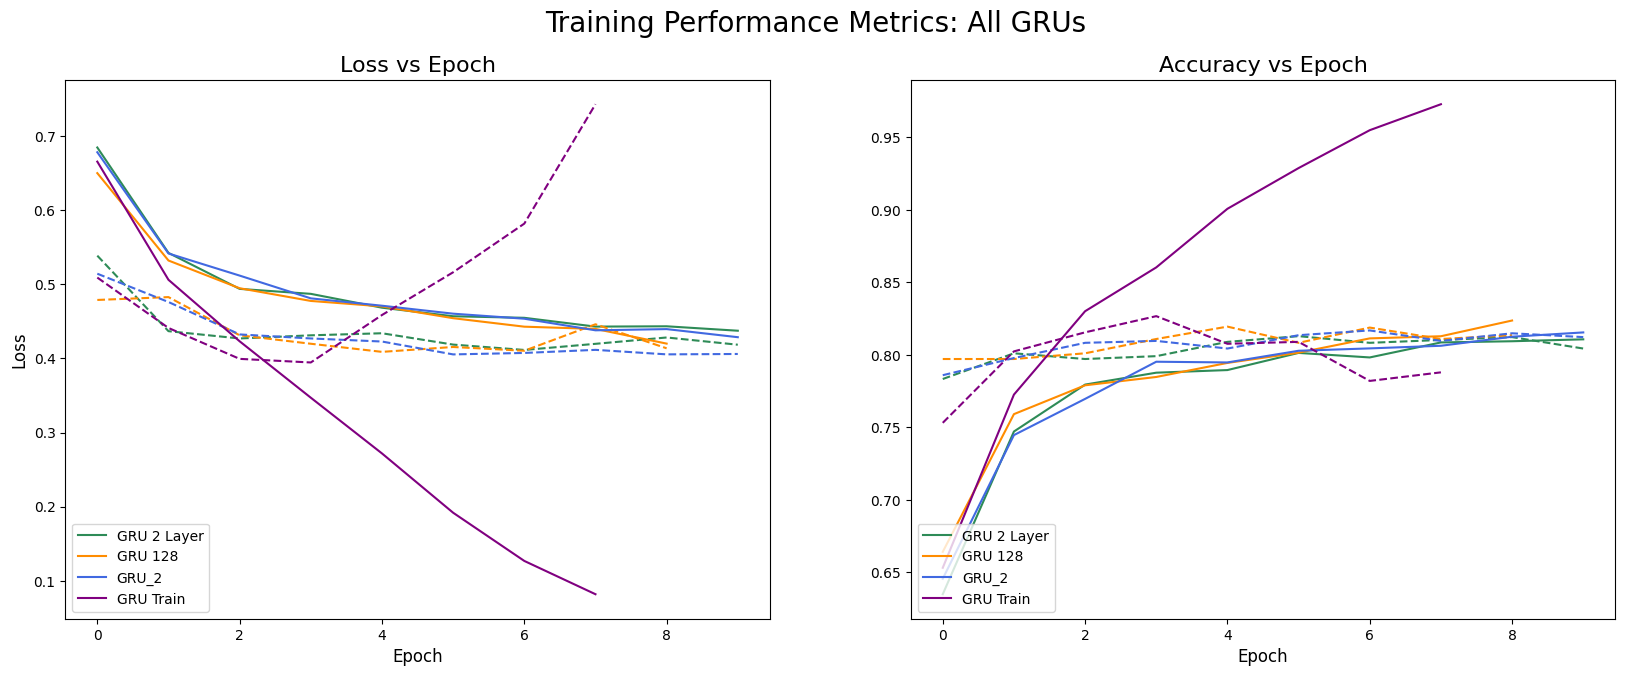

In [21]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

ax[0].plot(GRU_2_layer_hist.history['val_loss'], color='seagreen', linestyle='--')
ax[0].plot(GRU_2_layer_hist.history['loss'], color='seagreen', label='GRU 2 Layer')
ax[0].plot(GRU_128_hist.history['val_loss'], color='darkorange', linestyle='--')
ax[0].plot(GRU_128_hist.history['loss'], color='darkorange', label='GRU 128')
ax[0].plot(GRU_2_hist.history['val_loss'], color='royalblue', linestyle='--')
ax[0].plot(GRU_2_hist.history['loss'], color='royalblue', label='GRU_2')
ax[0].plot(GRU_train_hist.history['val_loss'], color='purple', linestyle='--')
ax[0].plot(GRU_train_hist.history['loss'], color='purple', label='GRU Train')
ax[0].set_title('Loss vs Epoch', fontsize=16)
ax[0].legend(loc='lower left')
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].set_xlabel('Epoch', fontsize=12)

ax[1].plot(GRU_2_layer_hist.history['val_accuracy'], color='seagreen', linestyle='--')
ax[1].plot(GRU_2_layer_hist.history['accuracy'], color='seagreen', label='GRU 2 Layer')
ax[1].plot(GRU_128_hist.history['val_accuracy'], color='darkorange', linestyle='--')
ax[1].plot(GRU_128_hist.history['accuracy'], color='darkorange', label='GRU 128')
ax[1].plot(GRU_2_hist.history['val_accuracy'], color='royalblue', linestyle='--')
ax[1].plot(GRU_2_hist.history['accuracy'], color='royalblue', label='GRU_2')
ax[1].plot(GRU_train_hist.history['val_accuracy'], color='purple', linestyle='--')
ax[1].plot(GRU_train_hist.history['accuracy'], color='purple', label='GRU Train')
ax[1].set_title('Accuracy vs Epoch', fontsize=16)
ax[1].legend(loc='lower left')
ax[1].set_xlabel('Epoch', fontsize=12)

fig.suptitle('Training Performance Metrics: All GRUs', fontsize=20)

All models save for the one with embedding training enabled are plateauing around 80% validation accuracy. This is likely implies the bottleneck in training is from a lack of data and not model complexity. Different techniques outside the scope of this week like ensembling or data augmentation could result in a better accuracy. For this project we will move forward with the GRU_2 model (simple but increased dropout).

In [28]:
# Testing the data
test_csv = pd.read_csv(test_path)
X_test = tokenizer.texts_to_sequences(test_csv["text"])
X_test = pad_sequences(X_test, maxlen=longest_tweet)

test_preds = GRU_2_model.predict(X_test, batch_size=64).ravel()
test_labels = (test_preds >= 0.5).astype(int)
test_labels

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


array([1, 1, 1, ..., 1, 1, 0])

In [31]:
#Saving the predictions to a csv to be submitted
kaggle_NLP_disaster_submission = pd.DataFrame({
    "id": test_csv['id'],
    "target": test_labels})

kaggle_NLP_disaster_submission.to_csv("/content/drive/MyDrive/Colab Notebooks/GloVe/kaggle_NLP_disaster_submission.csv", index=False)

In [33]:
kaggle_NLP_disaster_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


## **Conclusion**

All models tested in this hit performance plateaus near 80% accuracy despite giving increases in model complexity. As stated earlier this could be from a variety of factors involving limitations from training data or model complexity involving other things than increased layers and neurons. The best models tested in this scope were simple ones with the right amount of dropout to avoid overfitting.

Further models could encorporate ensembles, attention, VAEs, and/or try to augment the data to make better predictions.

